In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
document.title='Aurora app'

<IPython.core.display.Javascript object>

In [2]:
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd
from collections import OrderedDict
import json
import aurora
# import schemas.data_schemas
# from schemas.data_schemas import BatterySpecs, BatteryComposition, BatteryCapacity, BatteryMetadata, BatterySample, BatterySpecsJsonTypes, BatterySampleJsonTypes

import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
from aurora.interface.main import MainPanel

In [4]:
w_main = MainPanel()
display(w_main)

MainPanel(children=(HTML(value='<h2>Aurora</h2>'), Accordion(children=(Tab(children=(SampleFromId(children=(HT…

***AURORA* Autonomous Robotic Battery Innovation Platform**  BIG-MAP Stakeholder Initiative 2021

<table style="width: 40%; border-collapse: collapse; border-style: hidden; float: left;">
<tbody>
<tr>
<td style="width: 15%;"><img src="aurora/images/BIG-MAP_logo.png" alt="BIG-MAP" style="margin: 2px"/></td>
<td style="width: 15%;"><img src="aurora/images/Battery2030_logo.png" alt="Battery 2030+" style="margin: 2px"/></td>
<td style="width: 15%;"><img src="aurora/images/EU_logo.png" alt="European Commision" style=" margin: 2px"/></td>
<td style="width: 30%;"><img src="aurora/images/Empa_logo.png" alt="Empa" style="margin: 2px"/></td>
<td style="width: 25%;"><img src="aurora/images/EPFL_logo.png" alt="EPFL" style="margin: 2px"/></td>
</tr>
</tbody>
</table>


In [5]:
%aiida

Loaded AiiDA DB environment - profile name: default.

In [6]:
import aurora
from aurora.schemas.data_schemas import BatterySample as BatterySampleSchema, BatteryState as BatteryStateSchema
from aurora.schemas.cycling import Dummy, ElectroChemSequence
from aurora.schemas.tomato_0p2 import Tomato
from aiida.engine import submit
from aiida.plugins import DataFactory, CalculationFactory

ModuleNotFoundError: No module named 'aurora.schemas.data_schemas'

In [ ]:
import aiida_aurora
from aiida.orm import load_code

BatterySampleData = DataFactory('aurora.batterysample')
CyclingSpecsData = DataFactory('aurora.cyclingspecs')
TomatoSettingsData = DataFactory('aurora.tomatosettings')
BatteryCyclerExperiment = CalculationFactory('aurora.cycler')

TomatoMonitorData = DataFactory('calcmonitor.monitor.tomatobiologic')
TomatoMonitorCalcjob = CalculationFactory('calcmonitor.calcjob_monitor')

In [12]:
sample_node = aiida_aurora.data.BatterySample(w_main.selected_battery_sample.dict())
sample_node.store()

<BatterySample: uuid: e1ad7cd5-3af5-4b54-84a3-871e27acef68 (pk: 181)
{'capacity': {'units': 'mAh', 'actual': None, 'nominal': 45.0}, 'metadata': {'name': 'commercial-10', 'creation_process': 'Bought in a shop.', 'creation_datetime': '2022-06-28T05:59:00+00:00'}, 'battery_id': 10, 'composition': {'description': 'Li-based'}, 'form_factor': '2032', 'manufacturer': 'Conrad energy'}>

In [16]:
method_node = aiida_aurora.data.CyclingSpecs(w_main.selected_cycling_protocol.dict())
method_node.store()

<CyclingSpecs: uuid: 3d2870a0-ae67-455f-816a-55aba4fa11ad (pk: 182)
{'method': [{'name': 'CC_1', 'device': 'MPG2', 'technique': 'constant_current', 'parameters': {'time': {'label': 'Time:', 'units': 's', 'value': 18000.0, 'required': True, 'description': 'Maximum duration of the CC step', 'default_value': 0.0}, 'E_range': {'label': 'E range', 'units': '', 'value': '+-5.0 V', 'required': True, 'description': 'Select the voltage range of the potentiostat', 'default_value': 'auto'}, 'I_range': {'label': 'I range', 'units': '', 'value': '10 mA', 'required': True, 'description': 'Select the current range of the potentiostat', 'default_value': 'keep'}, 'current': {'label': 'Step current:', 'units': 'I', 'value': 'C/5', 'required': True, 'description': 'Current during the current step', 'default_value': 0.0}, 'is_delta': {'label': 'Δ$I$:', 'units': '', 'value': False, 'required': True, 'description': 'Is the step current a $\\Delta$ from previous step?', 'default_value': False}, 'n_cycles': {

In [20]:
tomato_sett = aurora.schemas.tomato_0p2.Tomato(
    snapshot = {'frequency': 1800, 'prefix': 'snapshot'})
tomato_sett_node = aiida_aurora.data.TomatoSettings(tomato_sett.dict())
tomato_sett_node.label = 'test-snapshot-1800'
tomato_sett_node.store()

<TomatoSettings: uuid: ce75f17b-ce43-4f97-acb5-9ea875b8ae8d (pk: 183)
{'output': {'path': None, 'prefix': None}, 'snapshot': {'path': None, 'prefix': 'snapshot', 'frequency': 1800}, 'verbosity': 'WARNING', 'unlock_when_done': False}>

In [29]:
b = aiida_aurora.calculations.BatteryCyclerExperiment.get_builder()
code = load_code('ketchup-0.2a1@ddm07162')
b.battery_sample = sample_node
b.code = code
b.technique = method_node
b.control_settings = tomato_sett_node
# b.metadata.dry_run = True

In [30]:
job = submit(b)

08/11/2022 09:15:53 AM <8537> aiida.engine.persistence: [DEBUG] Persisting process<184>
08/11/2022 09:15:53 AM <8537> aiida.engine.persistence: [DEBUG] Persisting process<184>


In [5]:
monitor_protocol = TomatoMonitorData(dict={
    'sources': {
        'output': {'filepath': 'snapshot.json', 'refresh_rate': 1800},
    },
    'options': {
        'check_type': 'discharge_capacity',
        'consecutive_cycles': 2,
        'threshold': 0.95,
    },
    'retrieve': ['results.json'],
    'retrieve_temporary': ['results.zip']
})  ## node-id = 190
monitor_builder = TomatoMonitorCalcjob.get_builder()
monitor_builder.code = load_code('monitor@localhost-verdi')
monitor_builder.metadata.options.parser_name = 'calcmonitor.cycler'
monitor_builder.monitor_protocols = {'monitor1': monitor_protocol}

In [13]:
job = load_node(184)
job.label = 'cycling-monitored-test-10'

In [7]:
monitor_builder.monitor_folder = job.outputs.remote_folder
mjob = submit(monitor_builder)

08/11/2022 09:31:05 AM <10382> aiida.engine.persistence: [DEBUG] Persisting process<191>
08/11/2022 09:31:06 AM <10382> aiida.engine.persistence: [DEBUG] Persisting process<191>


In [222]:
monitor_analysis(load_node(191), consecutive_cycles=2, threshold=0.95, discharge=True)

Monitored CalcJob:     <184> 'cycling-monitored-test-10'
Sample:                commercial-10
  capacities:          [73.88216747 79.10001391 80.98922509 82.00765067 82.59573382 82.96294708
 83.24429055 83.34628408 83.38854875 83.38679654 83.37071321 83.45405789
 83.52090614 83.59133901 83.62704527 83.63616046 83.65572378 83.66282342
 83.65704818 83.56541802 83.43944706 83.37628024 83.48317817 83.48288895
 83.40453476 83.44801587 83.47547548 83.35858467 83.30124255 83.14240699
 82.76339789 81.83307509 79.96146548 79.11642221 79.30991488 78.07831704
 77.51083035 76.32861138 77.59566392 78.96431723 79.98998916 80.10262353
 80.66395939 80.48022949 81.0540245  81.3657075  81.25884382 81.03689502
 80.92464723 80.75075546 80.38782188]
  relative capacities: [1.         1.0706239  1.09619449 1.10997895 1.11793869 1.12290895
 1.12671695 1.12809744 1.1286695  1.12864578 1.12842809 1.12955617
 1.13046096 1.13141428 1.13189756 1.13202094 1.13228573 1.13238182
 1.13230365 1.13106343 1.12935841 1.1

In [75]:
mjob = load_node(191)
# res = n.outputs.redirected_outputs['results']
# print(res.get_arraynames())
with open(f"{mjob.outputs.remote_folder.get_attribute('remote_path')}/snapshot.json", 'r') as fileobj:
    jsdata = json.load(fileobj)
data = get_data(jsdata["steps"][0]["data"])

In [76]:
data

{'time': array([0.00000000e+00, 7.78879881e-01, 5.77445986e+01, ...,
        1.10198407e+06, 1.10204407e+06, 1.10210407e+06]),
 'Ewe': array([3.2664609 , 3.36676455, 3.46684241, ..., 3.62639952, 3.62399364,
        3.62126732]),
 'I': array([ 0.        ,  0.00900024,  0.00899947, ..., -0.00899887,
        -0.00899887, -0.0090004 ]),
 'cn': array([0, 0, 0, ..., 0, 0, 0]),
 'time-cycles': array([  16359.35700011,   33968.24499989,   51989.49000001,
          70234.671     ,   88608.63700008,  107063.11599994,
         125579.47300005,  144116.85599995,  162662.51600003,
         181207.82500005,  199749.68300009,  218308.84699988,
         236883.26999998,  255473.2019999 ,  274070.94700003,
         292670.7349999 ,  311274.66899991,  329880.56999993,
         348485.22199988,  367068.71499991,  385623.61500001,
         404164.98699999,  422730.52900004,  441296.00900006,
         459844.34699988,  478402.12599993,  496966.09899998,
         515504.06699991,  534029.28800011,  552517.2

In [77]:
np.save('/home/aiida/data/commercial-10.npy', data)

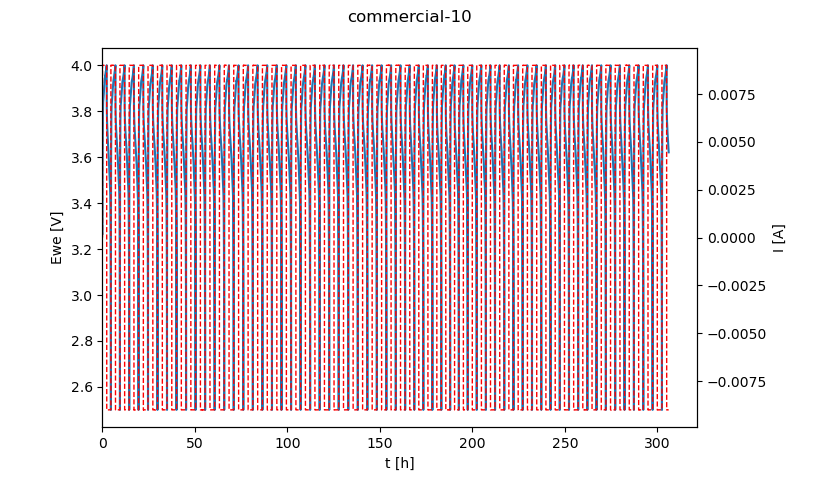

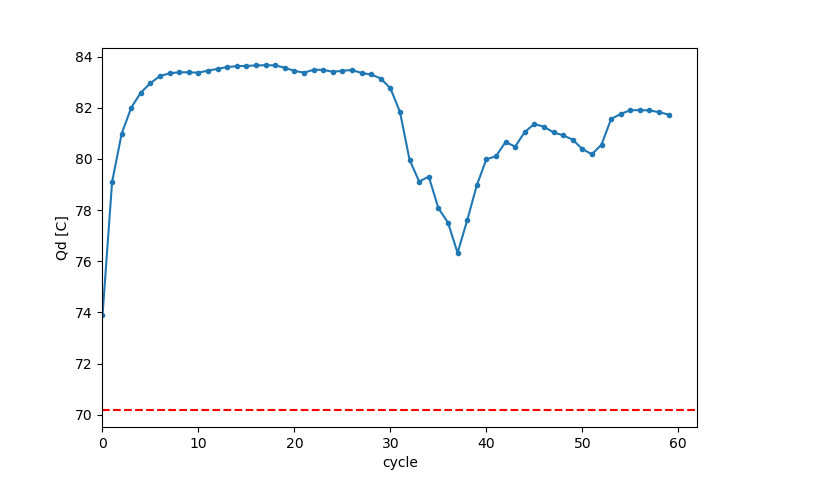

In [78]:
time = data['time'] / 3600
f, ax = plt.subplots(figsize=[8.2, 4.8])
plt.subplots_adjust(right=0.85, top=0.9)
ax.plot(time, data['Ewe'], lw=1.5, label='Ewe')
ax.set_xlabel('t [h]')
ax.set_ylabel('Ewe [V]')
ax2 = ax.twinx()
ax2.plot(time, data['I'], 'r--', lw=1, label='I')
ax2.set_ylabel('I [A]')
ax.set_xlim([0, None])
xra = ax.get_xlim()
f.suptitle('commercial-10')
plt.savefig('/home/aiida/data/commercial-10_Ewe_I.png', dpi=300)

f, ax = plt.subplots(figsize=[8.2, 4.8])
plt.subplots_adjust(right=0.85, top=0.9)
# ax.plot(data['time-cycles'] / 3600, data['Qd'], '.-')
ax.plot(data['Qd'], '.-')
# ax.set_xlabel('t [h]')
ax.set_xlabel('cycle')
ax.set_ylabel('Qd [C]')
# ax.set_xlim(xra)
ax.set_xlim([0, None])
ax.axhline(data['Qd'][0] * 0.95, ls='--', c='r')
plt.savefig('/home/aiida/data/commercial-10_Qd.png', dpi=300)

## second test

In [9]:
sample_node = aiida_aurora.data.BatterySample(w_main.selected_battery_sample.dict())
sample_node.store()

<BatterySample: uuid: 76b8e4d8-97e3-4fd4-8403-4055bfcf5edf (pk: 193)
{'capacity': {'units': 'mAh', 'actual': None, 'nominal': 45.0}, 'metadata': {'name': 'commercial-11', 'creation_process': 'Bought in a shop.', 'creation_datetime': '2022-06-28T05:59:00+00:00'}, 'battery_id': 11, 'composition': {'description': 'Li-based'}, 'form_factor': '2032', 'manufacturer': 'Conrad energy'}>

In [10]:
method_node = load_node(182)
settings_node = load_node(183)

In [11]:
b = aiida_aurora.calculations.BatteryCyclerExperiment.get_builder()
code = load_code('ketchup-0.2a1@ddm07162')
b.battery_sample = sample_node
b.code = code
b.technique = method_node
b.control_settings = settings_node
# b.metadata.dry_run = True

In [14]:
job = submit(b)
job.label = 'cycling-monitored-test-11'

08/11/2022 09:37:46 AM <10952> aiida.engine.persistence: [DEBUG] Persisting process<194>
08/11/2022 09:37:46 AM <10952> aiida.engine.persistence: [DEBUG] Persisting process<194>


In [15]:
monitor_protocol = load_node(190)
monitor_builder = TomatoMonitorCalcjob.get_builder()
monitor_builder.code = load_code('monitor@localhost-verdi')
monitor_builder.metadata.options.parser_name = 'calcmonitor.cycler'
monitor_builder.monitor_protocols = {'monitor1': monitor_protocol}

In [16]:
monitor_builder.monitor_folder = job.outputs.remote_folder
mjob = submit(monitor_builder)

08/11/2022 09:39:14 AM <10952> aiida.engine.persistence: [DEBUG] Persisting process<196>
08/11/2022 09:39:14 AM <10952> aiida.engine.persistence: [DEBUG] Persisting process<196>


In [74]:
monitor_analysis(load_node(196), consecutive_cycles=2, threshold=0.95, discharge=True)

Monitored CalcJob:     <194> 'cycling-monitored-test-11'
Sample:                commercial-11
  capacities:          [109.86959414  35.33525366  19.18305277  24.29897476]
  relative capacities: [1.         0.32161085 0.17459838 0.22116196]
Completed 4 cycles.
Below threshold for 3 cycles!


In [85]:
n = load_node(196)
res = n.outputs.redirected_outputs['results']
print(res.get_arraynames())

['step0_I_n', 'step0_I_s', 'step0_I_u', 'step0_uts', 'step0_Ewe_n', 'step0_Ewe_s', 'step0_Ewe_u', 'step0_index', 'step0_technique', 'step0_loop_number', 'step0_cycle_number']


Text(0.5, 0.98, 'commercial-11')

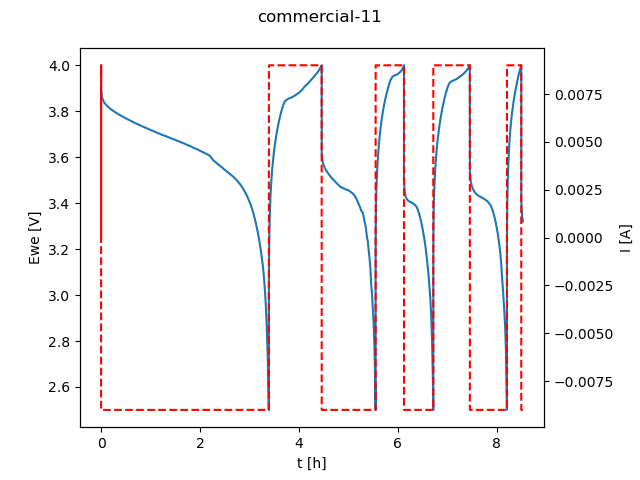

In [137]:
time = (res.get_array('step0_uts') - res.get_array('step0_uts')[0]) / 3600
f, ax = plt.subplots()
plt.subplots_adjust(right=0.85, top=0.9)
ax.plot(time, res.get_array('step0_Ewe_n'), label='Ewe')
ax.set_ylabel('Ewe [V]')
ax2 = ax.twinx()
ax2.plot(time, res.get_array('step0_I_n'), 'r--', label='I')
ax2.set_ylabel('I [A]')
ax.set_xlabel('t [h]')
f.suptitle('commercial-11')
# plt.figure()
# plt.plot(time, res.get_array('step0_loop_number'))

## analysis of results

In [49]:
import itertools

def get_capacities(data, discharge=True):
    uts, Ewe, I, cn,  Qc, Qd = [], [], [], [], [], []
    # extract raw data
    for ts in data:
        uts.append(ts["uts"])
        Ewe.append(ts["raw"]["Ewe"]["n"])
        I.append(ts["raw"]["I"]["n"])
        cn.append(ts["raw"]["cycle number"])
    t0 = uts[0]
    # convert to numpy arrays
    t = np.array(uts) - t0
    Ewe = np.array(Ewe)
    I = np.array(I)
    cn = np.array(cn)
    # find indices of sign changes in I
    idx = np.where(np.diff(np.sign(I)) != 0)[0]
    # integrate and store charge and discharge currents
    for ii, ie in enumerate(idx[1:]):
        i0 = idx[ii]
        q = np.trapz(I[i0:ie], t[i0:ie])
        if q > 0:
            Qc.append(q)
        else:
            Qd.append(abs(q))            
    if discharge:
        return np.array(Qd)
    else:
        return np.array(Qc)

def get_data(data, discharge=True):
    uts, Ewe, I, cn,  Qc, Qd = [], [], [], [], [], []
    # extract raw data
    for ts in data:
        uts.append(ts["uts"])
        Ewe.append(ts["raw"]["Ewe"]["n"])
        I.append(ts["raw"]["I"]["n"])
        cn.append(ts["raw"]["cycle number"])
    t0 = uts[0]
    # convert to numpy arrays
    t = np.array(uts) - t0
    Ewe = np.array(Ewe)
    I = np.array(I)
    cn = np.array(cn)
    # find indices of sign changes in I
    idx = np.where(np.diff(np.sign(I)) != 0)[0]
    # integrate and store charge and discharge currents
    for ii, ie in enumerate(idx[1:]):
        i0 = idx[ii]
        q = np.trapz(I[i0:ie], t[i0:ie])
        if q > 0:
            Qc.append(q)
        else:
            Qd.append(abs(q))
    data = {
        'time': t,
        'Ewe': Ewe,
        'I': I,
        'cn': cn,
        'time-cycles': t[idx[2::2]]
    }
    if discharge:
        data['Qd'] = np.array(Qd)
    else:
        data['Qc'] = np.array(Qc)
    return data

def analyze_dict_results(jsdata, consecutive_cycles, threshold, discharge):
    Qs = get_capacities(jsdata["steps"][0]["data"], discharge=discharge)
    print('  capacities:         ', Qs)
    print('  relative capacities:', Qs / Qs[0])

    print(f"Completed {len(Qs)} cycles.")
    if len(Qs) >= consecutive_cycles + 1:
        below_thresh = Qs < threshold * Qs[0]
        below_groups = [sum(1 for _ in g) for k, g in itertools.groupby(below_thresh) if k]
        for g in below_groups:
            if g > consecutive_cycles:
                print(f'Below threshold for {g} cycles!')

def monitor_analysis(monitor_node, consecutive_cycles, threshold=0.8, discharge=True):
    monitored_calcjob = monitor_node.inputs.monitor_folder.get_incoming().all_nodes()[0]
    sample = monitored_calcjob.inputs.battery_sample
    print(f"Monitored CalcJob:     <{monitored_calcjob.id}> '{monitored_calcjob.label}'")
    print(f"Sample:                {sample.label}")
    with open(f"{monitor_node.outputs.remote_folder.get_attribute('remote_path')}/snapshot.json", 'r') as fileobj:
        jsdata = json.load(fileobj)
    analyze_dict_results(jsdata, consecutive_cycles, threshold, discharge)

In [100]:
plt.close('all')

# Test 23-08

In [7]:
%aiida

Loaded AiiDA DB environment - profile name: default.

In [8]:
import aurora
from aurora.schemas.battery import BatterySample as BatterySampleSchema, BatteryState as BatteryStateSchema
from aurora.schemas.cycling import Dummy, ElectroChemSequence
# from aurora.schemas.tomato_0p2 import Tomato
from aiida.engine import submit
from aiida.plugins import DataFactory, CalculationFactory

In [9]:
import aiida_aurora
from aiida.orm import load_code

BatterySampleData = DataFactory('aurora.batterysample')
CyclingSpecsData = DataFactory('aurora.cyclingspecs')
TomatoSettingsData = DataFactory('aurora.tomatosettings')
BatteryCyclerExperiment = CalculationFactory('aurora.cycler')

TomatoMonitorData = DataFactory('calcmonitor.monitor.tomatobiologic')
TomatoMonitorCalcjob = CalculationFactory('calcmonitor.calcjob_monitor')

### Aurora-8 formation

In [10]:
# sample_node = aiida_aurora.data.BatterySampleData(w_main.selected_battery_sample.dict())
# sample_node.store()
sample_node = load_node(206)

In [11]:
# method_node = aiida_aurora.data.CyclingSpecsData(w_main.selected_cycling_protocol.dict())
# method_node.store()
method_node = load_node(207)

In [12]:
# tomato_sett = aurora.schemas.dgbowl_schemas.Tomato_0p2(
#     unlock_when_done = True,
# #     snapshot = {'frequency': 1800, 'prefix': 'snapshot'}
# )
# tomato_sett_node = aiida_aurora.data.TomatoSettingsData(tomato_sett.dict())
# tomato_sett_node.label = 'tomato-1'
# tomato_sett_node.store()
tomato_sett_node = load_node(208)

In [13]:
b = aiida_aurora.calculations.BatteryCyclerExperiment.get_builder()
code = load_code('ketchup-0.2rc1@ddm07162')
b.battery_sample = sample_node
b.code = code
b.technique = method_node
b.control_settings = tomato_sett_node
# b.metadata.dry_run = True

In [16]:
# aurora.schemas.dgbowl_schemas.conversion_map['0.2']['sample'](sample_node.get_dict())

Sample(name='190822_Aurora_8', capacity=0.002262)

In [17]:
job = submit(b)
job.label = 'formation-Aurora-8'

08/23/2022 08:42:42 AM <12508> aiida.engine.persistence: [DEBUG] Persisting process<222>
08/23/2022 08:42:43 AM <12508> aiida.engine.persistence: [DEBUG] Persisting process<222>


In [57]:
job = load_node(222)
print(job.label)

formation-Aurora-8


In [66]:
name = 'Aurora-8-formation'
with open(f"/home/aiida/data/formation-Aurora-8.json", 'r') as fileobj:
    jsdata = json.load(fileobj)
data = get_data(jsdata["steps"][0]["data"])

/tmp/ipykernel_12508/3731176464.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=[8.2, 4.8])


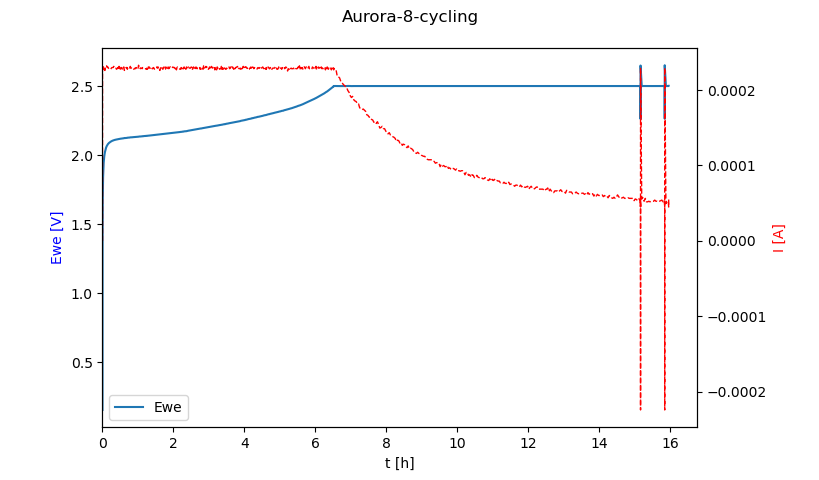

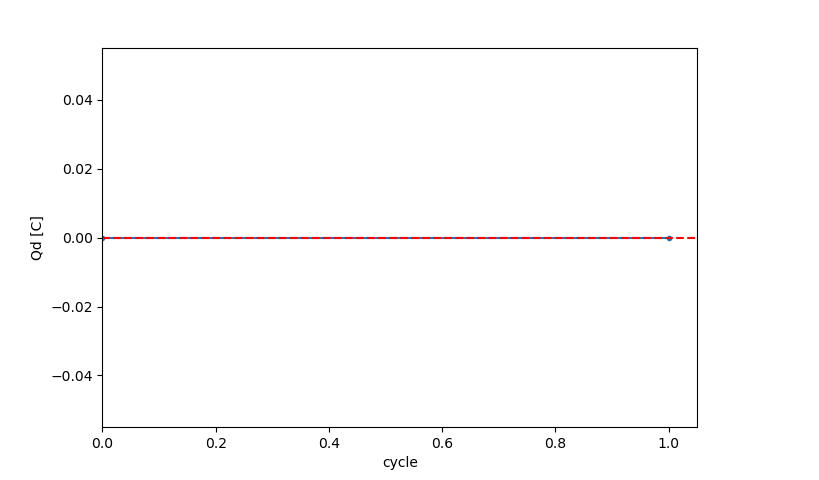

In [74]:
time = data['time'] / 3600
f, ax = plt.subplots(figsize=[8.2, 4.8])
plt.subplots_adjust(right=0.85, top=0.9)
ax.plot(time, data['Ewe'], lw=1.5, label='Ewe')
ax.set_xlabel('t [h]')
ax.set_ylabel('Ewe [V]', c='b')
ax.legend(loc='lower left')
ax2 = ax.twinx()
ax2.plot(time, data['I'], 'r--', lw=1, label='I')
ax2.set_ylabel('I [A]', c='r')
# ax2.legend()
ax.set_xlim([0, None])
xra = ax.get_xlim()
f.suptitle(name)
plt.savefig(f'/home/aiida/data/{name}_Ewe_I.png', dpi=300)

f, ax = plt.subplots(figsize=[8.2, 4.8])
plt.subplots_adjust(right=0.85, top=0.9)
# ax.plot(data['time-cycles'] / 3600, data['Qd'], '.-')
ax.plot(data['Qd'], '.-')
# ax.set_xlabel('t [h]')
ax.set_xlabel('cycle')
ax.set_ylabel('Qd [C]')
# ax.set_xlim(xra)
ax.set_xlim([0, None])
ax.axhline(data['Qd'][0] * 0.95, ls='--', c='r')
# plt.savefig('/home/aiida/data/commercial-10_Qd.png', dpi=300)

### Aurora-8 cycling

In [19]:
sample_node = load_node(206)

In [20]:
# method_node = aiida_aurora.data.CyclingSpecsData(w_main.selected_cycling_protocol.dict())
# method_node.label = 'cycling'
# method_node.store()
method_node = load_node(214)

In [21]:
tomato_sett = aurora.schemas.dgbowl_schemas.Tomato_0p2(
    unlock_when_done = False,
    snapshot = {'frequency': 600, 'prefix': 'snapshot'}
)
tomato_sett_node = aiida_aurora.data.TomatoSettingsData(tomato_sett.dict())
tomato_sett_node.label = 'tomato-monitor-600'
tomato_sett_node.store()

<TomatoSettingsData: uuid: d365d796-7673-4ea0-b919-e6c582336234 (pk: 224)
{'output': {'path': None, 'prefix': None}, 'snapshot': {'path': None, 'prefix': 'snapshot', 'frequency': 600}, 'verbosity': 'WARNING', 'unlock_when_done': False}>

In [22]:
b = aiida_aurora.calculations.BatteryCyclerExperiment.get_builder()
code = load_code('ketchup-0.2rc1@ddm07162')
b.battery_sample = sample_node
b.code = code
b.technique = method_node
b.control_settings = tomato_sett_node
# b.metadata.dry_run = True

In [23]:
job = submit(b)
job.label = 'cycling-Aurora-8'

08/23/2022 08:48:47 AM <12508> aiida.engine.persistence: [DEBUG] Persisting process<225>
08/23/2022 08:48:48 AM <12508> aiida.engine.persistence: [DEBUG] Persisting process<225>


In [24]:
monitor_protocol = TomatoMonitorData(dict={
    'sources': {
        'output': {'filepath': 'snapshot.json', 'refresh_rate': 600},
    },
    'options': {
        'check_type': 'discharge_capacity',
        'consecutive_cycles': 2,
        'threshold': 0.80,
    },
    'retrieve': ['results.json'],
    'retrieve_temporary': ['results.zip']
})  ## node-id = 190
monitor_builder = TomatoMonitorCalcjob.get_builder()
monitor_builder.code = load_code('monitor@localhost-verdi')
monitor_builder.metadata.options.parser_name = 'calcmonitor.cycler'
monitor_builder.monitor_protocols = {'monitor1': monitor_protocol}

In [25]:
monitor_builder.monitor_folder = job.outputs.remote_folder
mjob = submit(monitor_builder)

08/23/2022 08:49:38 AM <12508> aiida.engine.persistence: [DEBUG] Persisting process<228>
08/23/2022 08:49:38 AM <12508> aiida.engine.persistence: [DEBUG] Persisting process<228>


In [26]:
mjob.label = 'cycling-Aurora-8-monitor'

In [68]:
# monitor_analysis(load_node(196), consecutive_cycles=2, threshold=0.95, discharge=True)
job = load_node(225)
print(job.label)
name = 'Aurora-8-cycling'

analyze_dict_results(
    json.loads(job.outputs.retrieved.get_object_content('results.json')),
    consecutive_cycles=2, threshold=0.8, discharge=True
)

cycling-Aurora-8
  capacities:          []


IndexError: index 0 is out of bounds for axis 0 with size 0

['step0_I_n', 'step0_I_s', 'step0_I_u', 'step0_uts', 'step0_Ewe_n', 'step0_Ewe_s', 'step0_Ewe_u', 'step0_index', 'step0_technique', 'step0_loop_number', 'step0_cycle_number']


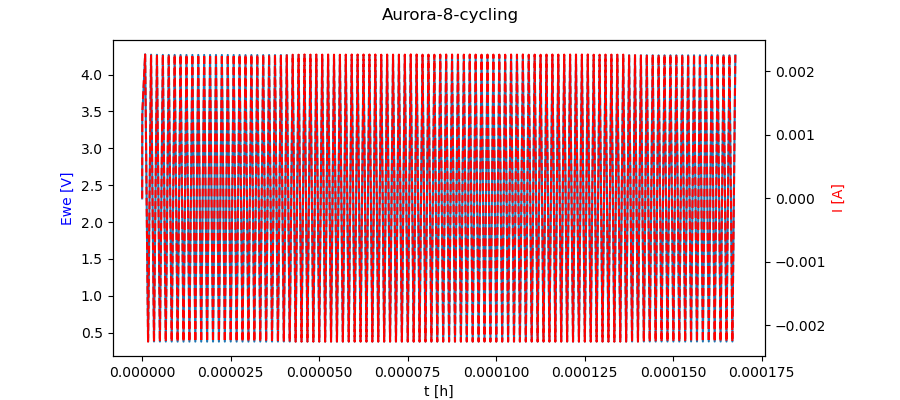

In [73]:
res = job.outputs.results
print(res.get_arraynames())

time = (res.get_array('step0_uts') - res.get_array('step0_uts')[0]) / 3600
f, ax = plt.subplots(figsize=(9,4))
plt.subplots_adjust(right=0.85, top=0.9)
ax.plot(time, res.get_array('step0_Ewe_n'), label='Ewe')
ax.set_ylabel('Ewe [V]', c='b')
ax2 = ax.twinx()
ax2.plot(time, res.get_array('step0_I_n'), 'r--', label='I')
ax2.set_ylabel('I [A]', c='r')
ax.set_xlabel('t [h]')
f.suptitle(name)
plt.savefig(f'/home/aiida/data/{name}_Ewe_I.png', dpi=300)